Let $p\in [n]$ be the mode we want to identify. Assume mode isolation, i.e., there is only one big mode. Say $$|\hat{x}_p| \gg \max_{k\neq p}|\hat{x}_k|.$$

The associated frequency we want to identify is $\theta:=p/n$.

Pick a random modulation $a$ in frequency domain. This is needed to make the noise components cancel away. Say $$\hat{y}_k=\hat{x}_k e^{2\pi i a k / n}.$$

Binning in its simplest form is a sum of all the coefficients in the bin. Say
$$U_a = \sum_k \hat{y}_k = \hat{x}_p e^{2\pi i a \theta} + \sum_{k\neq p} \hat{x}_k e^{2\pi i a k/n}.$$

In the absence of noise, then $$U_a = \hat{x}_p e^{2\pi i a \theta}.$$

This means
$$\frac{U_{a+1}}{U_a} = \frac{\hat{x}_p e^{2\pi i (a+1)\theta} }{\hat{x}_p e^{2\pi i a\theta} }=e^{2\pi i \theta}.$$

Hence, we recover $\theta$ as $$\theta = \frac{1}{2\pi} \arg \left( \frac{U_{a+1}}{U_a} \right).$$

Consider noise and the perturbation it makes to $U_a$: $$U_a -\hat{x}_p e^{2\pi i a \theta} = \sum_{k\neq p} \hat{x}_k e^{2\pi i a k/n}.$$

Define the error $E_a$ as $$E_a := e^{-2\pi i a \theta} U_a - \hat{x}_p = \sum_{k\neq p} \hat{x}_k e^{2\pi i a (k-p)/n}.$$

Clearly, $\mathbb{E} E_a = 0$ and $$\mathbb{E} |E_a|^2 = \sum_{k\neq p} |\hat{x}_k|^2.$$

Of course, $U_a = e^{2\pi i a \theta}(E_a + \hat{x}_p)$, so
$$\frac{U_{a+1}}{U_a} = \frac{\hat{x}_p e^{2\pi i (a+1)\theta} + e^{2\pi i (a+1) \theta} E_{a+1}}{\hat{x}_p e^{2\pi i a\theta} + e^{2\pi i a \theta} E_a}.$$

What we need is that $|E_{a+1}| \ll |\hat{x}_p|$. In other words, we want
$$\sqrt{\sum_{k\neq p} |\hat{x}_k|^2} \ll |\hat{x}_p|.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

# Noiseless estimate

Assume we have the solution $\hat{x}$. Randomly modulate. Give it very little noise and see that we can get pretty close to the solution.

In [28]:
# Some basic utilities.
# Data is bundled as a 2-tuple (xh, idx).

def modulate(data, a):
    """Helper. Assume idx=np.arange(n). Modulate components."""
    xh, idx = data
    n = len(xh)
    tmp = np.mod(a * idx, n).astype(float) / float(n)
    return xh * np.exp(2.0 * np.pi * 1j * tmp)


def compute_snr(data, p):
    """Compute SNR."""
    xh = data[0]
    tmp = np.abs(xh)  # xh=data[0].
    tmp = tmp * tmp
    tmp[p] = 0
    return np.abs(xh[p]) / np.sqrt(np.sum(tmp))


def setup(n, p, snr):
    """Return xhat with the desired SNR. Also return idx."""
    xh = np.random.randn(n) + 1j * np.random.randn(n)
    xh[p] = 0
    z = np.sqrt(np.sum(np.abs(xh) ** 2))
    xh /= (snr * z)
    xh[p] = 1.0
    return xh, np.arange(n)


def measure(data, a):
    """Simulate the binned coefficients."""
    return np.sum(modulate(data, a))


def new_pool():
    """Create new pool. Remember to close or you will have memory leaks!"""
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
    return pool

In [29]:
def estimator_simple(data):
    """Return estimated theta. Assume idx=arange(n). Note theta is in [0,1)."""
    xh, idx = data
    n = len(xh)
    a = np.random.randint(n)
    ua0 = measure(data, a)
    ua1 = measure(data, a + 1)
    theta = np.angle(ua1 / ua0) / (2 * np.pi)
    return np.mod(theta, 1.0)

In [31]:
def experiment1(estimator):
    """
    This experiment uses theta estimate function directly and does one trial.
    """
    n = 1109  # Prime. Not really needed.
    p = 250
    snr = 15
    theta = float(p) / n
    data = setup(n, p, snr)
    print 'SNR=%f' % compute_snr(data, p)
    print 'Theta=%f' % theta
    print 'Theta estimate=%f' % estimator(data)

    
experiment1(estimator_simple)

SNR=15.000000
Theta=0.225428
Theta estimate=0.228659


# Finding which half

Below, we use the noiseless estimate to guess which half the frequency is in. We repeat many many times, say 10000, to estimate the actual probability of guessing this right.

SNR=0.900000


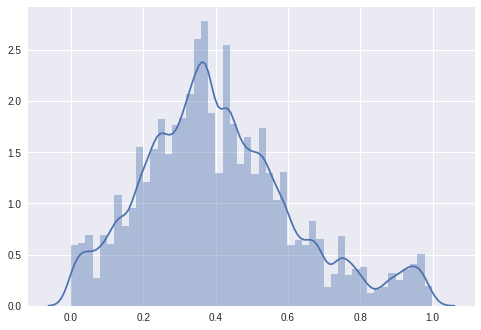

Probability of getting half right: 0.709820


In [33]:
def experiment2(estimator):
    """Experiment tries to see how often we get the first half right."""
    n = 1109
    p = 400  # In first half.
    snr = 0.9
    trials = 100000
    
    data = setup(n, p, snr)
    print 'SNR=%f' % compute_snr(data, p)
    count = 0
    pool = new_pool()  # Some brute force!
    results = np.array(pool.map(estimator, [data] * trials))
    pool.close()
    pool.join()
    sns.distplot(results); plt.show()

    # We know this is the first half. How often would we get this right?
    count = np.sum(results < 0.5)
    prob = float(count) / len(results)
    print 'Probability of getting half right: %f' % prob
    

experiment2(estimator_simple)

# Probability amplification

Probability of getting the right half is only about 0.66. However we can amplify this a lot, cheaply.

Recall Hoeffding's inequality. Let $X_1,\ldots,X_m$ be iid observations such that $\mathbb{E} X_i=\mu$ and $0\leq X_i \leq 1$. Then for any $\epsilon>0$, we have $$\Pr(|\bar{X} - \mu|\geq \epsilon) \leq 2\exp(-2m\epsilon^2).$$

In our case, say $X_i$ is indicator on $i$-th measurement giving the right half. Say $\bar{X} = 0.7$. Then the probability of guessing wrongly with $m$ measurements is, with $\epsilon=0.2$, bounded by
$$2\exp(-2m (0.04)).$$

This failure probability decreases exponentially with $m$ but the factor of $\epsilon^2$ is very punishing. If your single measurement failure probability is $0.6$, then $\epsilon^2 = 0.1^2 = 0.01$. This means you need $100$ measurements (!) just to decrease the failure probability by $e^{-2}\simeq 0.14$. Horrible. On the other hand, if your single measurement failure probability is $0.7$, then $\epsilon^2 = 0.2^2 = 0.04$ which means you need $1/4$ as many measurements.

Of course, boosting single measurement failure probability comes at a cost. Some simple optimization would be needed here to find good parameters.

In [34]:
def half_estimate(data, m, estimator):
    """Guess which half theta is in. Use m measurements."""
    xh, idx = data
    n = len(xh)
    results = []
    for i in xrange(m):
        results.append(estimator(data))
    results = np.mod(results, 1.0)
    count = np.sum(results > 0.5)
    return count * 2 > m  # Voting. True if we think it is second half.

In [68]:
def experiment3_helper(input):
    return half_estimate(*input)


def experiment3(estimator):
    """Just try to get first bit. Repeat many times to see how good the probability amplification is."""
    n = 1109
    p = 400  # In first half.
    snr = 0.9
    trials = 10000
    m = 30
    data = setup(n, p, snr)
    
    pool = new_pool()  # Some brute force!
    results = np.array(pool.map(experiment3_helper, [(data, m, estimator)] * trials))
    pool.close()
    pool.join()
    prob = float(np.sum(results)) / trials
    print 'Chance of getting half wrong with %d measurements: %e' % (m, prob)


experiment3(estimator_simple)

Chance of getting half wrong with 30 measurements: 2.100000e-03


# Multiscale

Extend the above to find each bit of the frequency. To do so, we repeatedly dilate the frequencies. We assume a prime $n$ to make this easier.

In [40]:
def dilate(xh):
    """Returns xh with frequencies dilated."""
    n = len(xh)
    out = np.zeros(n, dtype=xh.dtype)
    for i in xrange(n):
        out[(i * 2) % n] = xh[i]
    return np.array(out)
    

def recover_mode(n, bits):
    ans = 0
    b = len(bits)
    for i in xrange(b):
        if bits[i]:
            ans += 2**(-(i + 1))
    # Get us to middle of the bucket.
    # Basically, if we get 0.1011, we pretend ans is 0.1011100000000.
    ans += 2 ** (-(b + 1))
    ans = int(np.round(ans * n))
    return ans


def get_mode_dilation(data, m, b, estimator):
    """Compute b number of bits. Each bit uses m measurements."""
    xh, idx = data
    results = []
    for i in xrange(b):
        results.append(half_estimate((xh, idx), m, estimator))
        xh = dilate(xh)
    return recover_mode(len(xh), results)

In [41]:
def experiment4_helper(input):
    return get_mode_dilation(*input)


def experiment4(estimator):
    """Check how many times we get mode location exactly right."""
    n = 1109
    p = 400  # In first half.
    snr = 0.9
    trials = 5000
    m = 30
    b = int(np.floor(np.log2(n))) + 1
    data = setup(n, p, snr)
    pool = new_pool()  # Some brute force!
    results = np.array(pool.map(experiment4_helper, [(data, m, b, estimator)] * trials))
    pool.close()
    pool.join()
    count = np.sum(results == p)
    prob = float(count) / trials
    print 'Probability of getting mode location exactly right = %f' % prob


experiment4(estimator_simple)

Probability of getting mode location exactly right = 0.655200


Chance of getting the mode location exactly right is around $0.65$ which is decent.

However, it looks bad considering that for the first bit, we know we have a very high chance of getting it right. Recall failure probability is $\ll 0.05$ due to the probability amplification. We would expect to be able to union bound over $b$ levels. However, it doesn't work that way. When dilated, some frequency might be close to the decision edges of $0$ and $0.5$ such that any small perturbation would lead to that bit being wrong.

Let $\theta=400/1109\simeq 0.36$. And $2\theta\simeq 0.72$, which is ok, quite far away from $0.5$. And $4\theta\simeq 0.44$. This one is not good. It is really close to $0.5$. Some other dangerous bits are $32\theta \simeq 0.54$ and $64 \theta \simeq 0.08$ and $2^{15} \theta \simeq 0.94$.

For our actual application, this mode would be randomly shuffled such that we can define a small $\Delta$ and ensure that with good probability, $\theta,2\theta,4\theta,\ldots$ are all at least $\Delta$ away from the decision boundaries of $0$ and $0.5$, and $\Delta \sim \frac{1}{B} \frac{1}{ |\hat{x}_p| } \sqrt{\sum_{k\neq p} |\hat{x}_k|^2}$ where $B$ is number of bins.

# Multiscale attempt #2

Earlier, we dilate $\hat{x}$. Instead of doing that, we can just work with a different modulation. Recall $$U_a \simeq \hat{x}_p e^{2\pi i a\theta}$$ where $\theta=p/n$ is what we want to identify.

In the past, we do $U_a,U_{a+1}$ to get which half $\theta$ is in.

See that $$U_{a+2} \simeq \hat{x}_p e^{2\pi i (a+2)\theta}$$
such that $U_{a+2}/U_a \simeq e^{2\pi i (2\theta)}$. So this can give us the second bit of $\theta$.

In other words, we need the following modulations in frequency domain (or translates in time domain): $a, a+1, a+2, a+4, a+8, a+16, a+32, \ldots$.

In [46]:
def bits_estimator_simple(data, b):
    """Return b half estimates. Note that no estimator is needed. We use simple ratios."""
    n = len(data[0])
    a = np.random.randint(n)
    ua0 = measure(data, a)
    results = []
    for i in xrange(b):
        ua1 = measure(data, (a + 2 ** i) % n)
        tmp = ua1 / ua0
        # First half means imag component is >=0. Add true if in second half.
        results.append(np.imag(tmp) < 0)
    return results


def bits_estimator_combined(data, m, b, bits_estimator):
    """Use bits_estimator to get b bits. Repeat m times. Do voting."""
    results = []
    for i in xrange(m):
        # For each random modulation a, we will attempt to get b bits.
        # There are m of these random modulations.
        results.append(bits_estimator(data, b))
    results = np.array(results)
    results = np.sum(results, axis=0)
    return results * 2 > m

In [48]:
def experiment5_helper(input):
    data, m, b, bits_estimator = input
    xh = data[0]
    return recover_mode(len(xh), bits_estimator_combined(data, m, b, bits_estimator))
    

def experiment5(bits_estimator):
    """Check how many times we get mode location exactly right."""
    n = 1109
    p = 400  # In first half.
    snr = 0.9
    trials = 5000
    m = 30
    b = int(np.floor(np.log2(n))) + 1
    data = setup(n, p, snr)
    pool = new_pool()  # Some brute force!
    results = np.array(pool.map(experiment5_helper, [(data, m, b, bits_estimator)] * trials))
    pool.close()
    pool.join()
    count = np.sum(results == p)
    prob = float(count) / trials
    print 'Probability of getting mode location exactly right = %f' % prob


experiment5(bits_estimator_simple)

Probability of getting mode location exactly right = 0.687400


This is somewhat consistent with what we got earlier. The overall probability of getting the exact mode location right is $\sim 0.65$. However, we do roughly half as much work because we use the same $a$ for different bits.

# Matrix pencil

To identify a bit, we have used $U_a, U_{a+1}$. How about getting $U_{a-1}$ as well? As we will see somewhere else, computing $U_{a-1}$ is pretty cheap due to symmetry, so we might as well get it. Given $U_{a-1}, U_a, U_{a+1}$, what is a good way to get at the first bit / which half $\theta$ is in?

Form the matrix $A := \frac{1}{2} \left( \begin{array}{ccc} U_a & U_{a-1} \\ U_{a+1} & U_a \end{array} \right)$.

Let $A_1$ be $A$ with bottom row removed and $A_2$ be $A$ with top row removed. Matrix pencil method says we want to compute the eigenvalues of $A_1^+ A_2$.

Before that, we want to denoise using SVD. Hopefully this improves our chance of getting the bit right.

Compute SVD and truncate to rank $1$ since we expect only one mode. Say the truncated SVD is $\sigma u v^H$. Let $v_1$ be $v$ with bottom row removed, i.e., the top number. Let $v_2$ be $v$ with top row removed, i.e., the bottom number. Then the eigenvalue we seek is the conjugate of $v_1^+ v_2$ which is equal to $v_1 \bar{v}_2/|v_1|^2$.

# Finding which half with matrix pencil

Recall that earlier, using simple ratios, the chance of getting the first half / first bit is about 0.7. Let's see if using matrix pencil can improve this.

In [24]:
def mp_helper(ua, ua1, ua2):
    """Returns angle given three sample points: 0, 1, -1 respectively."""
    mat = np.array([[ua, ua2], [ua1, ua]])
    _, sigma, vh = np.linalg.svd(mat)
    assert vh.shape == (2, 2)
    vh = vh[0, :]  # Dominant vector.
    v1 = vh[0]
    v2 = vh[1]
    w = v1 * np.conj(v2)
    print sigma
    #print vh
    print w
    theta = np.angle(w) / (2 * np.pi)
    return np.mod(theta, 1.0)


def estimator_mp(data):
    """
    Return estimated theta. Assume idx=arange(n). Note theta is in [0,1).
    """
    xh, idx = data
    n = len(xh)
    a = np.random.randint(n)
    #a = 0
    ua = measure(data, a)
    ua1 = measure(data, a + 1)
    ua2 = measure(data, a - 1)
    return mp_helper(ua, ua1, ua2)


#mp_helper(-15.3 - 5.2*1j, 8.0+3.0*1j, -1.5+3.5*1j)
#mp_helper(-2.3+5.2*1j, -5.5-3.1*1j, 4.0+3.0*1j)
mp_helper(2.3+5.2*1j, 5.5-3.1*1j, 4.0+3.0*1j)

[ 9.80673965  5.77476038]
(0.339518387858-0.347477093621j)


0.8731563041736512

In [60]:
experiment1(estimator_mp)

SNR=15.000000
Theta=0.225428
Theta estimate=0.219705


SNR=0.900000


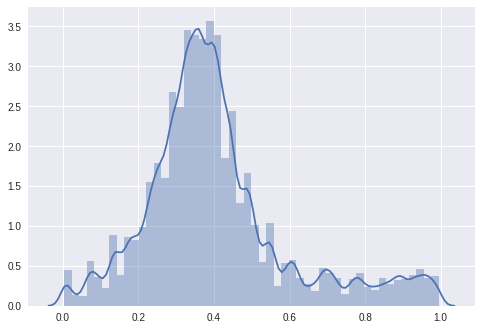

Probability of getting half right: 0.800390


In [61]:
experiment2(estimator_mp)

This looks considerably better than using the simple ratio! Previously, it is about 0.7. Now it is about 0.8!

In [69]:
experiment3(estimator_mp)

Chance of getting half wrong with 30 measurements: 0.000000e+00


In [63]:
experiment4(estimator_mp)

Probability of getting mode location exactly right = 0.835000


Using the simple estimator, probability of getting the mode location exactly right is only $~0.65$. This is so much better.

In [65]:
def bits_estimator_mp(data, b):
    """Return b half estimates. Note that no estimator is needed. We use simple ratios."""
    n = len(data[0])
    a = np.random.randint(n)
    ua = measure(data, a)
    results = []
    for i in xrange(b):
        ua1 = measure(data, (a + 2 ** i) % n)
        ua2 = measure(data, (a - 2 ** i) % n)
        theta = mp_helper(ua, ua1, ua2)
        results.append(theta > 0.5)
    return results

In [67]:
experiment5(bits_estimator_mp)

Probability of getting mode location exactly right = 0.837800


This probability is somewhat consistent with experiment4 where we repeatedly dilate $\hat{x}$ instead of tweaking the modulation factors.